In [3]:
import os
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.mixed_precision import set_global_policy
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
try:
    import psutil
    monitor_memory = True
except ImportError:
    monitor_memory = False
    print("psutil not installed; memory monitoring disabled. Install with: pip install psutil")


set_global_policy('mixed_float16')


gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

data_dir = 'D:/Major Project/Dataset/New_Dataset'
batch_size = 64
target_size = (224, 224)
image_paths = []
labels = []
classes = sorted(os.listdir(data_dir))
num_classes = len(classes)

for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(class_dir, img_name)
            image_paths.append(img_path)
            labels.append(class_name)


df = pd.DataFrame({'image_path': image_paths, 'label': labels})
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)


class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weight_dict = dict(enumerate(class_weights))

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    channel_shift_range=20,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

workers = min(multiprocessing.cpu_count(), 4)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    workers=workers,
    use_multiprocessing=True,
    max_queue_size=10
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    workers=workers,
    use_multiprocessing=True,
    max_queue_size=10
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    workers=workers,
    use_multiprocessing=True,
    max_queue_size=10
)

def generator_to_tfdata(generator, cache=False):
    dataset = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None, 224, 224, 3], [None, num_classes])
    )
    if cache:
        dataset = dataset.cache()
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = generator_to_tfdata(train_generator, cache=False)
val_dataset = generator_to_tfdata(val_generator, cache=False)
test_dataset = generator_to_tfdata(test_generator, cache=False)

steps_per_epoch = len(train_df) // batch_size
validation_steps = len(val_df) // batch_size
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6
Found 58400 validated image filenames belonging to 73 classes.
Found 7300 validated image filenames belonging to 73 classes.
Found 7300 validated image filenames belonging to 73 classes.
Steps per epoch: 912
Validation steps: 114


In [ ]:
def build_model(num_classes):
    base_model = VGG19(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    predictions = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
    model = models.Model(inputs=base_model.input, outputs=predictions)
    return model, base_model

model, base_model = build_model(num_classes)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("Initial Model (All Base Layers Frozen):")
print(f"Total parameters: {model.count_params()}")
print(f"Trainable parameters: {sum([w.shape.num_elements() for w in model.trainable_weights])}")
print(f"Non-trainable parameters: {model.count_params() - sum([w.shape.num_elements() for w in model.trainable_weights])}")

csv_logger_initial = CSVLogger('D:/Major Project/Models/VGG19/training_history_initial.csv', separator=',', append=False)
early_stopping_initial = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True)
model_checkpoint_initial = ModelCheckpoint('D:/Major Project/Models/VGG19/best_initial_model.keras', monitor='val_accuracy', mode='max', save_best_only=True)
reduce_lr_initial = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6)

history_initial = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=[early_stopping_initial, model_checkpoint_initial, csv_logger_initial, reduce_lr_initial],
    verbose=1
)

Initial Model (All Base Layers Frozen):
Total parameters: 20099465
Trainable parameters: 75081
Non-trainable parameters: 20024384
Epoch 1/50
913/913 [==============================] - 742s 810ms/step - loss: 1.2311 - accuracy: 0.6388 - val_loss: 0.6598 - val_accuracy: 0.7818 - lr: 0.0010
Epoch 2/50
913/913 [==============================] - 736s 807ms/step - loss: 0.6562 - accuracy: 0.7835 - val_loss: 0.5601 - val_accuracy: 0.8104 - lr: 0.0010
Epoch 3/50
913/913 [==============================] - 733s 803ms/step - loss: 0.5671 - accuracy: 0.8085 - val_loss: 0.5084 - val_accuracy: 0.8284 - lr: 0.0010
Epoch 4/50
913/913 [==============================] - 728s 797ms/step - loss: 0.5242 - accuracy: 0.8212 - val_loss: 0.4683 - val_accuracy: 0.8364 - lr: 0.0010
Epoch 5/50
913/913 [==============================] - 726s 796ms/step - loss: 0.4876 - accuracy: 0.8322 - val_loss: 0.4500 - val_accuracy: 0.8468 - lr: 0.0010
Epoch 6/50
913/913 [==============================] - 724s 793ms/step - los

In [20]:
def build_model(num_classes):
    base_model = VGG19(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    predictions = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
    model = models.Model(inputs=base_model.input, outputs=predictions)
    return model, base_model

model, base_model = build_model(num_classes)
model.load_weights('D:/Major Project/Models/VGG19/best_initial_model.keras')

for layer in base_model.layers[-4:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

csv_logger_finetune = CSVLogger('D:/Major Project/Models/VGG19/training_history_finetune.csv', separator=',', append=False)
early_stopping_finetune = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True)
model_checkpoint_finetune = ModelCheckpoint('D:/Major Project/Models/VGG19/best_finetune_model.keras', monitor='val_accuracy', mode='max', save_best_only=True)
reduce_lr_finetune = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6)

history_finetune = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=[early_stopping_finetune, model_checkpoint_finetune, csv_logger_finetune, reduce_lr_finetune],
    verbose=1
)

Epoch 1/20
912/912 [==============================] - 641s 688ms/step - loss: 0.2320 - accuracy: 0.9189 - val_loss: 0.2192 - val_accuracy: 0.9309 - lr: 1.0000e-05
Epoch 2/20
912/912 [==============================] - 605s 662ms/step - loss: 0.1909 - accuracy: 0.9330 - val_loss: 0.1949 - val_accuracy: 0.9391 - lr: 1.0000e-05
Epoch 3/20
912/912 [==============================] - 585s 642ms/step - loss: 0.1646 - accuracy: 0.9428 - val_loss: 0.1752 - val_accuracy: 0.9450 - lr: 1.0000e-05
Epoch 4/20
912/912 [==============================] - 574s 630ms/step - loss: 0.1506 - accuracy: 0.9464 - val_loss: 0.1766 - val_accuracy: 0.9428 - lr: 1.0000e-05
Epoch 5/20
912/912 [==============================] - 607s 666ms/step - loss: 0.1322 - accuracy: 0.9534 - val_loss: 0.1584 - val_accuracy: 0.9487 - lr: 1.0000e-05
Epoch 6/20
912/912 [==============================] - 591s 648ms/step - loss: 0.1211 - accuracy: 0.9569 - val_loss: 0.1572 - val_accuracy: 0.9538 - lr: 1.0000e-05
Epoch 7/20
912/912 [==

In [21]:
model.save_weights('D:/Major Project/Models/VGG19/all_weights_vgg19.keras')
model.save('D:/Major Project/Models/VGG19/final_model_vgg19.keras')

In [38]:
import math
test_steps = math.ceil(len(test_df) / batch_size)
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

115/115 [==============================] - 42s 359ms/step - loss: 0.1124 - accuracy: 0.9703
Test Loss: 0.1124, Test Accuracy: 0.9703


115/115 [==============================] - 42s 366ms/step


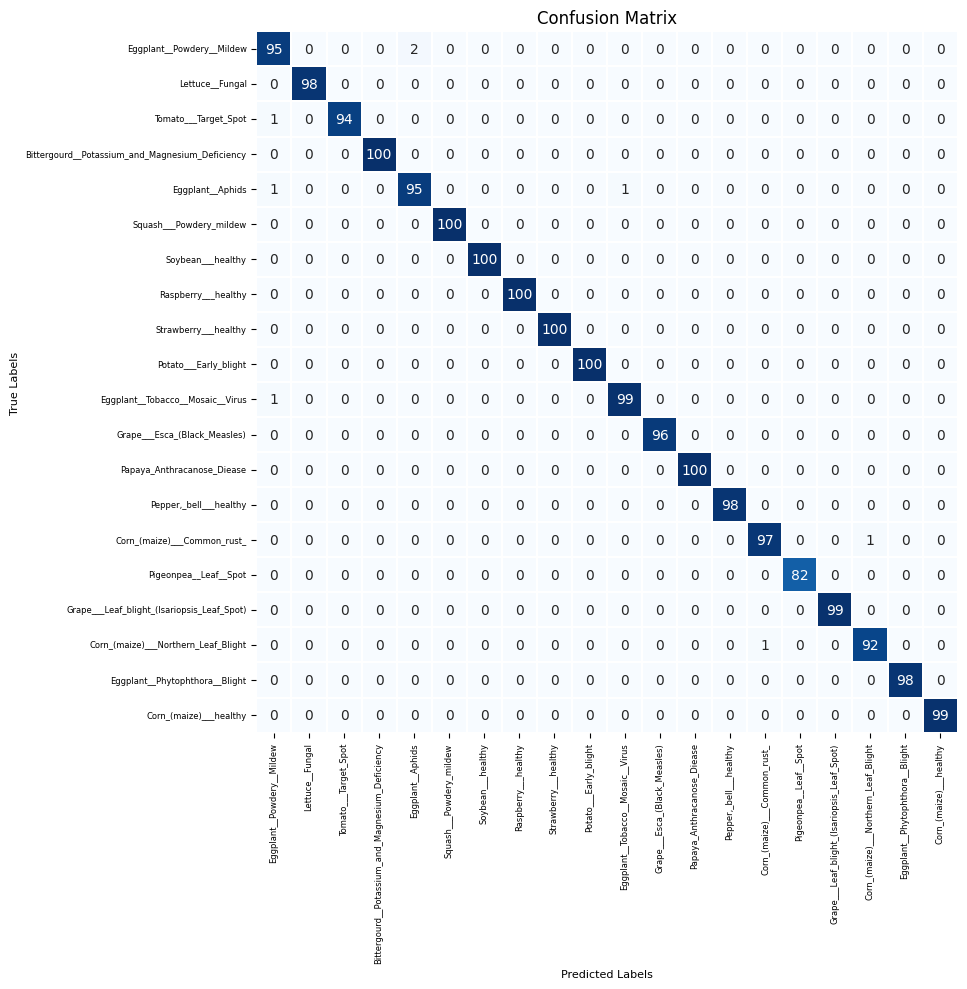

In [43]:
import random
class_labels = list(test_generator.class_indices.keys())
y_pred = model.predict(test_generator, steps=test_steps, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes[:len(y_pred_classes)]
if len(y_true) != len(y_pred_classes):
    print("Warning: Mismatch in lengths. Truncating y_true to match y_pred_classes.")
    y_true = y_true[:len(y_pred_classes)]
y_true = np.array(y_true)
y_pred_classes = np.array(y_pred_classes)

num_classes_to_show = 20
if len(class_labels) < num_classes_to_show:
    num_classes_to_show = len(class_labels)

random_classes = random.sample(class_labels, num_classes_to_show)
random_class_indices = [class_labels.index(cls) for cls in random_classes]
mask_true = np.isin(y_true, random_class_indices)

filtered_y_true_temp = y_true[mask_true]
filtered_y_pred_temp = y_pred_classes[mask_true]
mask_pred = np.isin(filtered_y_pred_temp, random_class_indices)

filtered_y_true = filtered_y_true_temp[mask_pred]
filtered_y_pred_classes = filtered_y_pred_temp[mask_pred]

label_mapping = {idx: i for i, idx in enumerate(random_class_indices)}
filtered_y_true_mapped = np.array([label_mapping[label] for label in filtered_y_true])
filtered_y_pred_mapped = np.array([label_mapping[label] for label in filtered_y_pred_classes])

cm = confusion_matrix(filtered_y_true_mapped, filtered_y_pred_mapped)

plt.figure(figsize=(10, 10)) 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=random_classes, yticklabels=random_classes,
            cbar=False, linewidths=0.3, square=True)
plt.xticks(rotation=90, fontsize=6)
plt.yticks(fontsize=6)
plt.xlabel('Predicted Labels', fontsize=8)
plt.ylabel('True Labels', fontsize=8)
plt.title('Confusion Matrix', fontsize=12)
plt.tight_layout()
plt.savefig('D:/Major Project/Models/VGG19/confusion_matrix_vgg19.png')
plt.show()

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
class_labels = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred_classes, target_names=class_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv('D:/Major Project/resnet/classification_report.csv')
print("Classification report saved to 'D:/Major Project/resnet/classification_report.csv'")
print("\nClassification Report:")
print(report_df)

predictions_df = pd.DataFrame({
    'True_Label': [class_labels[i] for i in y_true],
    'Predicted_Label': [class_labels[i] for i in y_pred_classes],
    'Confidence': np.max(y_pred, axis=1)
})
predictions_df.to_csv('D:/Major Project/Models/VGG19/test_predictions.csv', index=False)
print("Test predictions saved to 'D:/Major Project/Models/VGG19/test_predictions.csv'")

Classification report saved to 'D:/Major Project/resnet/classification_report.csv'

Classification Report:
                              precision    recall  f1-score      support
Apple___Apple_scab             1.000000  0.990000  0.994975   100.000000
Apple___Black_rot              0.990099  1.000000  0.995025   100.000000
Apple___Cedar_apple_rust       0.990099  1.000000  0.995025   100.000000
Apple___healthy                0.980198  0.990000  0.985075   100.000000
Bittergourd__Downy_Mildew      0.980000  0.980000  0.980000   100.000000
...                                 ...       ...       ...          ...
Tomato___Tomato_mosaic_virus   0.970588  0.990000  0.980198   100.000000
Tomato___healthy               0.930693  0.940000  0.935323   100.000000
accuracy                       0.970274  0.970274  0.970274     0.970274
macro avg                      0.971113  0.970274  0.970247  7300.000000
weighted avg                   0.971113  0.970274  0.970247  7300.000000

[76 rows x 4 col

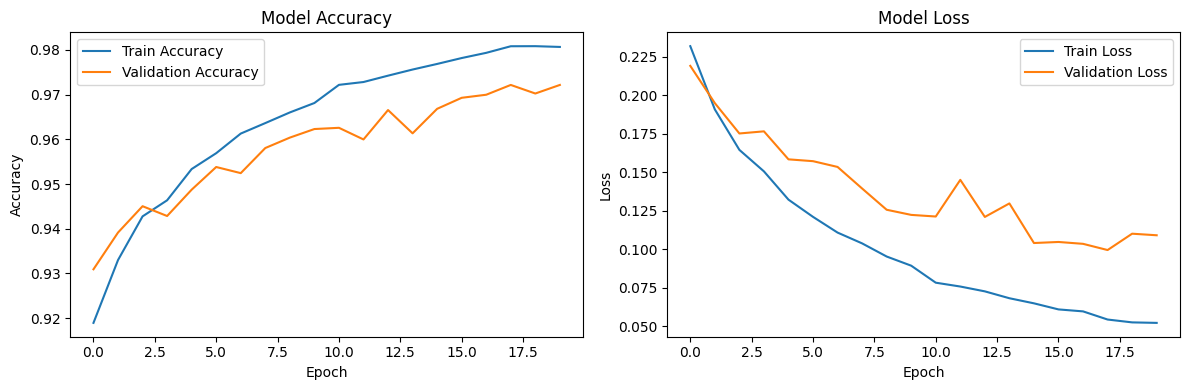

In [50]:
# Training history for fine-tuned epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_finetune.history['accuracy'], label='Train Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_finetune.history['loss'], label='Train Loss')
plt.plot(history_finetune.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('D:/Major Project/Models/VGG19/training_history_fine_vgg19.png')
plt.show()

Loaded training history from 'training_history_initial.csv' and 'training_history_fine.csv'
Initial training epochs: 39
Fine-tuning epochs: 20
Total epochs: 59
Training history plot saved to 'D:/Major Project/Models/VGG19/training_history_combined.png'


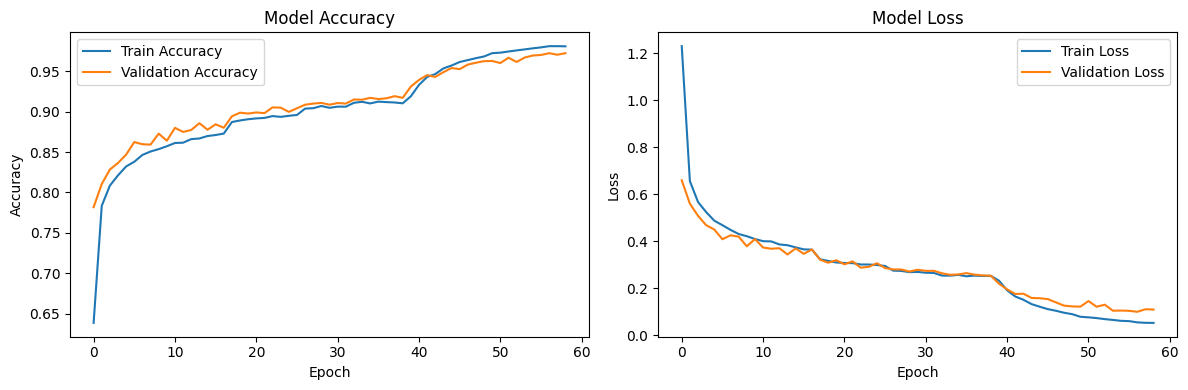

In [56]:
#Training history for both initial and fine-tuned epochs
try:
    history_initial_df = pd.read_csv('D:/Major Project/Models/VGG19/training_history_initial.csv')
    history_fine_df = pd.read_csv('D:/Major Project/Models/VGG19/training_history_finetune.csv')
    print("Loaded training history from 'training_history_initial.csv' and 'training_history_fine.csv'")
except Exception as e:
    print(f"Error loading history CSVs: {e}")
    print("Please ensure 'training_history_initial.csv' and 'training_history_finetune.csv' exist in 'D:/Major Project/Models/VGG19'")
    exit(1)

required_columns = ['accuracy', 'val_accuracy', 'loss', 'val_loss']
if not all(col in history_initial_df.columns for col in required_columns) or \
   not all(col in history_fine_df.columns for col in required_columns):
    print("Error: CSV files must contain columns: 'accuracy', 'val_accuracy', 'loss', 'val_loss'")
    exit(1)

history_initial = {
    'accuracy': history_initial_df['accuracy'].tolist(),
    'val_accuracy': history_initial_df['val_accuracy'].tolist(),
    'loss': history_initial_df['loss'].tolist(),
    'val_loss': history_initial_df['val_loss'].tolist()
}
history_finetune = {
    'accuracy': history_fine_df['accuracy'].tolist(),
    'val_accuracy': history_fine_df['val_accuracy'].tolist(),
    'loss': history_fine_df['loss'].tolist(),
    'val_loss': history_fine_df['val_loss'].tolist()
}
print(f"Initial training epochs: {len(history_initial['accuracy'])}")
print(f"Fine-tuning epochs: {len(history_finetune['accuracy'])}")
print(f"Total epochs: {len(history_initial['accuracy']) + len(history_finetune['accuracy'])}")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_initial['accuracy'] + history_finetune['accuracy'], label='Train Accuracy')
plt.plot(history_initial['val_accuracy'] + history_finetune['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_initial['loss'] + history_finetune['loss'], label='Train Loss')
plt.plot(history_initial['val_loss'] + history_finetune['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('D:/Major Project/Models/VGG19/training_history_combined.png')
print("Training history plot saved to 'D:/Major Project/Models/VGG19/training_history_combined.png'")

In [ ]:
final_model_vgg19

In [5]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

model_path = 'D:/Major Project/Models/VGG19/final_model_vgg19.keras'
try:
    model = tf.keras.models.load_model(model_path)
    print(f"Loaded Keras model from '{model_path}'")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Falling back to rebuilding model and loading weights")
    def build_model(num_classes):
        base_model = tf.keras.applications.ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
        for layer in base_model.layers:
            layer.trainable = False
        x = base_model.output
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        predictions = tf.keras.layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
        model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)
        return model, base_model
    try:
        num_classes = len(test_generator.class_indices)
    except NameError:
        print("Error: test_generator not defined. Please define num_classes or test_generator.")
        sys.exit(1)
    model, base_model = build_model(num_classes)
    for layer in base_model.layers[-17:]:
        layer.trainable = True
    try:
        model.load_weights('D:/Major Project/Models/VGG19/all_weights_vgg19.keras')
        print("Loaded weights from 'all_weights_resnet50.keras'")
    except Exception as e:
        print(f"Error loading weights: {e}")
        sys.exit(1)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False  
try:
    tflite_model = converter.convert()
except Exception as e:
    print(f"Error during float16 conversion: {e}")
    print("Falling back to float32 conversion without quantization")
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
    converter._experimental_lower_tensor_list_ops = False
    tflite_model = converter.convert()
    
tflite_path = 'D:/Major Project/Models/VGG19/vgg19_model_float16.tflite'
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)
print(f"Saved TFLite model to '{tflite_path}'")
print(f"TFLite model size: {os.path.getsize(tflite_path) / (1024 * 1024):.2f} MB")

Loaded Keras model from 'D:/Major Project/Models/VGG19/final_model_vgg19.keras'


INFO:tensorflow:Assets written to: C:\Users\subbh\AppData\Local\Temp\tmpzhxa25ba\assets


INFO:tensorflow:Assets written to: C:\Users\subbh\AppData\Local\Temp\tmpzhxa25ba\assets


Saved TFLite model to 'D:/Major Project/Models/VGG19/vgg19_model_float16.tflite'
TFLite model size: 38.36 MB
